# Glass Quality Prediction  Weekend Hackathon 6

We humans have been using glass since ancient times for a variety of applications from building construction to making decorative objects. With technology, glass and its applications have evolved, and today, we have different varieties of glass used for very different purposes from a computer monitor to a bulletproof car window depending on the grade of the glass produced. And not all grades or varieties are manufactured the same way. In this data science challenge, you as a data scientist must use the given data to predict the grade of the glass produced based on the given factors.

**Given are 15 distinguishing factors that can provide insight into what grade of the glass is being produced. Your objective as a data scientist is to build a machine learning model that can predict the grade of glass based on the given factors.**

**Data Description:-**
The unzipped folder will have the following files.

- Train.csv – 1358 observations.
- Test.csv – 583 observations.
- Sample Submission – Sample format for the submission.
- Target Variable: class

## Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.metrics import log_loss

from sklearn.ensemble import ExtraTreesClassifier

## Import Dataset

In [2]:
train = pd.read_csv("data/Train.csv")
test = pd.read_csv("data/Test.csv")
sub = pd.read_excel("data/Sample_Submission.xlsx")

In [3]:
train.head()

,grade_A_Component_1,grade_A_Component_2,max_luminosity,thickness,xmin,xmax,ymin,ymax,pixel_area,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5,class
0,0,1,150,36,144,172,947225,947332,439,439.099273,0,0,1,0,0,1
1,1,0,134,55,1144,1152,2379058,2379624,329,329.205616,1,0,0,0,0,1
2,1,0,135,65,950,974,1038442,1036754,300,300.120598,0,0,0,0,0,2
3,0,1,123,35,41,220,1705580,1705604,6803,6803.778622,0,0,1,0,0,1
4,1,0,138,69,462,466,1088124,1086579,251,251.401943,0,0,0,0,0,2


In [4]:
test.head()

,grade_A_Component_1,grade_A_Component_2,max_luminosity,thickness,xmin,xmax,ymin,ymax,pixel_area,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5
0,1,0,123,65,33,54,1646439,1646893,632,632.391749,0,1,0,0,0
1,0,1,158,99,125,132,189874,189529,421,421.928609,0,0,0,0,0
2,0,1,120,35,64,75,12986873,12986862,272,272.212214,1,0,0,0,0
3,0,1,130,39,57,177,309634,310824,3312,3312.310581,0,0,1,0,0
4,1,0,142,75,23,79,5368307,5367467,862,862.499179,0,0,0,0,0


In [5]:
train[['grade_A_Component_1','grade_A_Component_2','x_component_1','x_component_2','x_component_3','x_component_4','x_component_5']].head() 

,grade_A_Component_1,grade_A_Component_2,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5
0,0,1,0,0,1,0,0
1,1,0,1,0,0,0,0
2,1,0,0,0,0,0,0
3,0,1,0,0,1,0,0
4,1,0,0,0,0,0,0


**Note:** Grade_A feature and x_component are one hot encoded.
- grade_A_Component_1 and grade_A_component_2 represent the same, there is a dummy variable.
- So, **grade_A_Component_1** is removed from features.
- In case of x_component, that is not the case all the 5 features are needed.

In [6]:
train[['pixel_area','log_area']].head()

,pixel_area,log_area
0,439,439.099273
1,329,329.205616
2,300,300.120598
3,6803,6803.778622
4,251,251.401943


**Note**: Since the interger part of pixel_area and log_area are same, we remove pixel_area or log_area by considering the feature importance and log_losss metric.

## Features

These are features which are created

In [7]:
def create_features(df):
    
    df['x'] = df['xmax']-df['xmin']
    df['y'] = df['ymax']-df['ymin']
    df['area'] = df['x']*abs(df['y'])
    df['volume'] = df['area']*df['thickness']
    df['diff_area'] = df['log_area'] - df['pixel_area']
    
    return df

In [8]:
train = create_features(train)
test = create_features(test)

## EDA

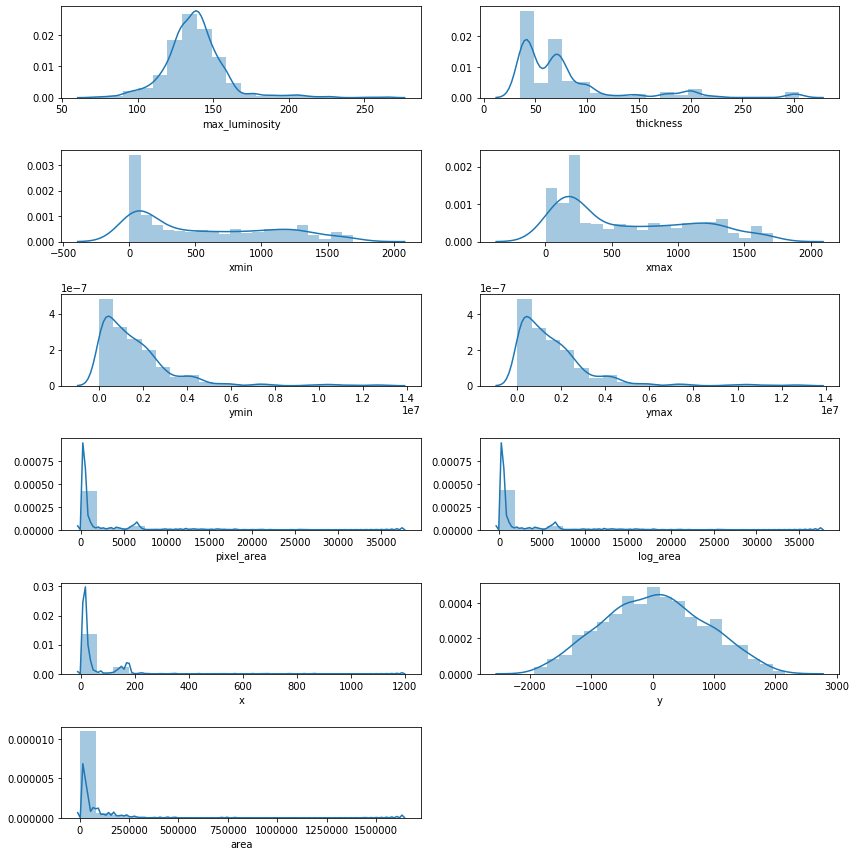

In [9]:
# Plot the distribution plots for the numeric features
fig, ax = plt.subplots(nrows=6, ncols=2,figsize=(12,12))

ax = ax.flatten()
i=0

for feat in ['max_luminosity', 'thickness','xmin','xmax','ymin', 'ymax','pixel_area','log_area','x','y','area']:
    sns.distplot(a=train[feat],bins=20,ax=ax[i])
    i+=1
    
fig.delaxes(ax[11])
fig.tight_layout()

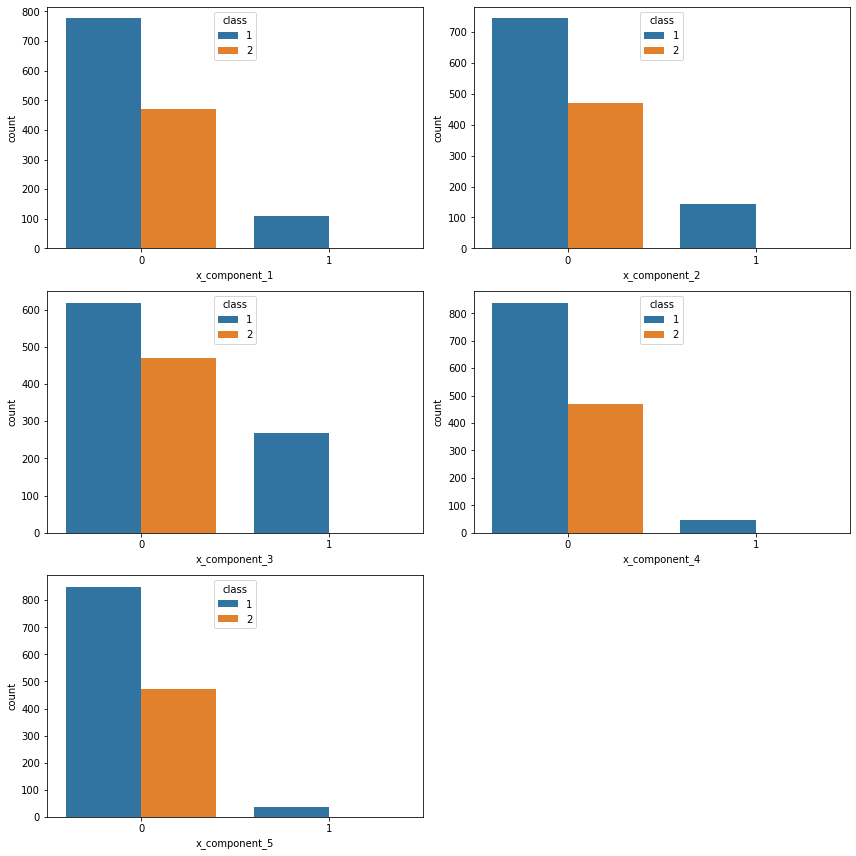

In [10]:
# Plot the distribution plots for the numeric features
fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(12,12))

ax = ax.flatten()
i=0

for feat in ['x_component_1','x_component_2','x_component_3','x_component_4','x_component_5']:
    sns.countplot(x=feat,data=train,hue='class',ax=ax[i])
    i+=1
    
fig.delaxes(ax[5])
fig.tight_layout()

**Note:** From these plots we can see that x_component with 1's are all classified as class 1.
- This can be used directly for classification with probabilty as 1 for class 1.

In [11]:
# Preprocessing result 
def confident_results(test,sub):
    for i in range(0,test.shape[0]):
        if(test['x_component_1'][i]==1):
            sub[1][i] =1.0
            sub[2][i] =0.0
        elif(test['x_component_2'][i]==1):
            sub[1][i] =1.0
            sub[2][i] =0.0
        elif(test['x_component_3'][i]==1):
            sub[1][i] =1.0
            sub[2][i] =0.0
        elif(test['x_component_4'][i]==1):
            sub[1][i] =1.0
            sub[2][i] =0.0
        elif(test['x_component_5'][i]==1):
            sub[1][i] =1.0
            sub[2][i] =0.0
    return sub

# features

After trying models with different features these features provided lower log_loss

In [12]:
features = list(set(train.columns)-set(['class','grade_A_Component_1','y','pixel_area','diff_area'])) 
target = 'class'
features

['x_component_2',
 'max_luminosity',
 'ymax',
 'x_component_5',
 'log_area',
 'xmin',
 'grade_A_Component_2',
 'ymin',
 'x_component_3',
 'x_component_1',
 'volume',
 'x',
 'area',
 'x_component_4',
 'xmax',
 'thickness']

In [13]:
def metric(y,y0):
    return log_loss(y,y0)

In [14]:
def k_fold_cross_valid(model,train,features,target,n_splits=5):
    
    X = train[features].copy()
    y = train[target].copy()

    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)
    kf.get_n_splits(X)
    res = []

    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train,y_train)
        y_pred = model.predict_proba(X_test)
        res.append(metric(y_test,y_pred))
        
    print("LogLoss:",np.array(res).mean())   

In [15]:
model = ExtraTreesClassifier(random_state=11)
k_fold_cross_valid(model,train,features,target,n_splits=5)

LogLoss: 0.2845587601255075


In [16]:
model = ExtraTreesClassifier(random_state=11)
model.fit(train[features],train[target])
y_pred = model.predict_proba(test[features])
sub = pd.DataFrame(y_pred,columns=[1,2])

In [17]:
sub = confident_results(test,sub)
sub.to_excel("extratrees_addv1.xls",index=False)

In [18]:
sub.head()

,1,2
0,1.00,0.00
1,0.15,0.85
2,1.00,0.00
3,1.00,0.00
4,0.59,0.41
